<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-the-libraries" data-toc-modified-id="Load-the-libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load the libraries</a></span></li><li><span><a href="#Load-the-data" data-toc-modified-id="Load-the-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load the data</a></span></li><li><span><a href="#Train-test-split" data-toc-modified-id="Train-test-split-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Train test split</a></span></li><li><span><a href="#Modelling:-lgb" data-toc-modified-id="Modelling:-lgb-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Modelling: lgb</a></span></li><li><span><a href="#Model-interpretation-using-eli5" data-toc-modified-id="Model-interpretation-using-eli5-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Model interpretation using eli5</a></span></li><li><span><a href="#Model-interpretation-using-lime" data-toc-modified-id="Model-interpretation-using-lime-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Model interpretation using lime</a></span></li><li><span><a href="#Model-interpretation-using-shap" data-toc-modified-id="Model-interpretation-using-shap-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Model interpretation using shap</a></span></li></ul></div>

# Load the libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

pd.options.plotting.backend = "matplotlib"
pd.set_option('max_columns',100)

import time,os,json
time_start_notebook = time.time()
home = os.path.expanduser('~')
SEED=100

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import sklearn
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

import joblib
import lightgbm as lgb

[(x.__name__,x.__version__) for x in [np,pd,sns,sklearn,lgb]]

[('numpy', '1.18.4'),
 ('pandas', '1.1.0'),
 ('seaborn', '0.10.1'),
 ('sklearn', '0.23.1'),
 ('lightgbm', '2.3.1')]

In [2]:
def print_scores(ytest,ypreds):
    # for auc score we need to binarize
    labels = [0, 1, 2, 3]
    ytest_bin = label_binarize(ytest, classes=labels)
    ypreds_bin = label_binarize(ypreds, classes=labels)
    a = roc_auc_score(ytest_bin,ypreds_bin,
                      average='macro',multi_class='ovo')
    
    # precision recall
    p = precision_score(ytest,ypreds,average='macro')
    r = recall_score(ytest,ypreds,average='macro')
    f = f1_score(ytest,ypreds,average='macro')
    print(f'Precision: {p: .2f}')
    print(f'Recall   : {r: .2f}')
    print(f'F1-score : {f: .2f}')
    print(f'AUC      : {f: .2f}')
    

    c = classification_report(ytest, ypreds)
    print(c)

    cm = confusion_matrix(ytest,ypreds)
    names = list('ABCD')
    df_cm = pd.DataFrame(cm,index=names,columns=names)
    df_cm = df_cm.style.background_gradient()
    display(df_cm)

In [3]:
df_eval = pd.DataFrame({'Model': [],
                        'Description':[],
                        'Accuracy':[],
                        'Precision':[],
                        'Recall':[],
                        'F1':[],
                        'AUC': []
                    })

# Load the data

In [4]:
df_raw = pd.read_csv('../data/raw/train.csv')
print(df_raw.shape)

df_raw.head(2).append(df_raw.tail(2))

(8068, 11)


ID  Gender Ever_Married  Age Graduated  Profession  Work_Experience  \
0     462809    Male           No   22        No  Healthcare              1.0   
1     462643  Female          Yes   38       Yes    Engineer              NaN   
8066  467299  Female           No   27       Yes  Healthcare              1.0   
8067  461879    Male          Yes   37       Yes   Executive              0.0   

     Spending_Score  Family_Size  Var_1 Segmentation  
0               Low          4.0  Cat_4            D  
1           Average          3.0  Cat_4            A  
8066            Low          4.0  Cat_6            B  
8067        Average          3.0  Cat_4            B

In [5]:
df = pd.read_csv('../data/processed/clean_data.csv')
print(df.shape)

df.head(2).append(df.tail(2))

(8068, 38)


Gender  Ever_Married  Age  Graduated  Work_Experience  Spending_Score  \
0          0             0   22          0              1.0               0   
1          1             1   38          1              3.0               1   
8066       1             0   27          1              1.0               0   
8067       0             1   37          1              0.0               1   

      Family_Size  Segmentation  Ever_Married_NA  Graduated_NA  Profession_NA  \
0             4.0             3                0             0              0   
1             3.0             0                0             0              0   
8066          4.0             1                0             0              0   
8067          3.0             1                0             0              0   

      Work_Experience_NA  Family_Size_NA  Var_1_NA  Age_cat  Family_Size_cat  \
0                      0               0         0        0                1   
1                      1               0         0        1                1   
8066                   0               0         0        0                1   
8067                   0               0         0        1                1   

      Work_Experience_cat  Profession_Artist  Profession_Doctor  \
0                       0                  0                  0   
1                       1                  0                  0   
8066                    0                  0                  0   
8067                    0                  0                  0   

      Profession_Engineer  Profession_Entertainment  Profession_Executive  \
0                       0                         0                     0   
1                       1                         0                     0   
8066                    0                         0                     0   
8067                    0                         0                     1   

      Profession_Healthcare  Profession_Homemaker  Profession_Lawyer  \
0                         1                     0                  0   
1                         0                     0                  0   
8066                      1                     0                  0   
8067                      0                     0                  0   

      Profession_Marketing  Var_1_Cat_1  Var_1_Cat_2  Var_1_Cat_3  \
0                        0            0            0            0   
1                        0            0            0            0   
8066                     0            0            0            0   
8067                     0            0            0            0   

      Var_1_Cat_4  Var_1_Cat_5  Var_1_Cat_6  Var_1_Cat_7  gen_mar  gen_grad  \
0               1            0            0            0        0         0   
1               1            0            0            0        3         3   
8066            0            0            1            0        1         3   
8067            1            0            0            0        2         2   

      gen_spend  grad_spend  grad_spend_gen  
0             0           0               0  
1             4           4              13  
8066          1           1              10  
8067          3           4               4

# Train test split

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
target = 'Segmentation'

df_Xtrain_orig, df_Xtest, ser_ytrain_orig, ser_ytest = train_test_split(
    df.drop(target,axis=1), df[target],shuffle=True,
    test_size=0.2, random_state=SEED, stratify=df[target])

df_Xtrain, df_Xvalid, ser_ytrain, ser_yvalid = train_test_split(
    df_Xtrain_orig, ser_ytrain_orig,
    test_size=0.2, random_state=SEED, stratify=ser_ytrain_orig)

ytrain = ser_ytrain.to_numpy().ravel()
yvalid = ser_yvalid.to_numpy().ravel()
ytest = ser_ytest.to_numpy().ravel()

print(f"df             : {df.shape}")

print(f"\ndf_Xtrain_orig : {df_Xtrain_orig.shape}")
print(f"ser_ytrain_orig: {ser_ytrain_orig.shape}")

print(f"\ndf_Xtrain      : {df_Xtrain.shape}")
print(f"ser_ytrain     : {ser_ytrain.shape}")

print(f"\ndf_Xvalid      : {df_Xvalid.shape}")
print(f"ser_yvalid     : {ser_yvalid.shape}")

print(f"\ndf_Xtest       : {df_Xtest.shape}")
print(f"ser_ytest      : {ser_ytest.shape}")

df_Xtrain_orig.head(2)

df             : (8068, 38)

df_Xtrain_orig : (6454, 37)
ser_ytrain_orig: (6454,)

df_Xtrain      : (5163, 37)
ser_ytrain     : (5163,)

df_Xvalid      : (1291, 37)
ser_yvalid     : (1291,)

df_Xtest       : (1614, 37)
ser_ytest      : (1614,)


Gender  Ever_Married  Age  Graduated  Work_Experience  Spending_Score  \
3582       0             1   27          0              2.0               0   
6827       0             0   41          1              3.0               0   

      Family_Size  Ever_Married_NA  Graduated_NA  Profession_NA  \
3582          2.0                0             0              0   
6827          1.0                0             0              0   

      Work_Experience_NA  Family_Size_NA  Var_1_NA  Age_cat  Family_Size_cat  \
3582                   1               0         0        0                0   
6827                   1               0         0        1                0   

      Work_Experience_cat  Profession_Artist  Profession_Doctor  \
3582                    0                  0                  0   
6827                    1                  0                  0   

      Profession_Engineer  Profession_Entertainment  Profession_Executive  \
3582                    0                         0                     1   
6827                    0                         1                     0   

      Profession_Healthcare  Profession_Homemaker  Profession_Lawyer  \
3582                      0                     0                  0   
6827                      0                     0                  0   

      Profession_Marketing  Var_1_Cat_1  Var_1_Cat_2  Var_1_Cat_3  \
3582                     0            0            0            0   
6827                     0            0            0            0   

      Var_1_Cat_4  Var_1_Cat_5  Var_1_Cat_6  Var_1_Cat_7  gen_mar  gen_grad  \
3582            1            0            0            0        2         0   
6827            0            0            1            0        0         2   

      gen_spend  grad_spend  grad_spend_gen  
3582          0           0               0  
6827          0           1               1

In [8]:
cols_all = df_Xtrain_orig.columns.to_list()
cols_no_na = [i for i in cols_all if not i.endswith('_NA')]


cross = ['gen_mar', 'gen_grad', 'gen_spend',
         'grad_spend', 'grad_spend_gen']
cols_no_na_no_cross = [i for i in cols_no_na if i not in cross]
cols_no_na_no_cross

['Gender',
 'Ever_Married',
 'Age',
 'Graduated',
 'Work_Experience',
 'Spending_Score',
 'Family_Size',
 'Age_cat',
 'Family_Size_cat',
 'Work_Experience_cat',
 'Profession_Artist',
 'Profession_Doctor',
 'Profession_Engineer',
 'Profession_Entertainment',
 'Profession_Executive',
 'Profession_Healthcare',
 'Profession_Homemaker',
 'Profession_Lawyer',
 'Profession_Marketing',
 'Var_1_Cat_1',
 'Var_1_Cat_2',
 'Var_1_Cat_3',
 'Var_1_Cat_4',
 'Var_1_Cat_5',
 'Var_1_Cat_6',
 'Var_1_Cat_7']

In [9]:
features = cols_no_na

Xtr = df_Xtrain_orig[features]
Xtx = df_Xtest[features]
Xvd = df_Xvalid[features]

ytr = ser_ytrain_orig.to_numpy().ravel()
ytx = ser_ytest.to_numpy().ravel()
yvd = ser_yvalid.to_numpy().ravel()

In [10]:
dtrain = lgb.Dataset(Xtr, ytr)
dvalid = lgb.Dataset(Xvd, yvd, reference=dtrain)
# I have used dtrain and dvalid in optuna grid search only.
# lgb required raw dataframe for prediction, no need of dtest.

# Modelling: lgb

In [11]:
features = cols_all

Xtr = df_Xtrain_orig[features]
Xtx = df_Xtest[features]
Xvd = df_Xvalid[features]

ytr = ser_ytrain_orig.to_numpy().ravel()
ytx = ser_ytest.to_numpy().ravel()
yvd = ser_yvalid.to_numpy().ravel()

In [12]:
model_grid_random = joblib.load('../outputs/lgb_randomsearch_best_model.pkl')
model_grid_random

LGBMClassifier(colsample_bytree=0.6, learning_rate=0.03, min_data_in_leaf=1,
               n_estimators=375, num_class=4, num_leaves=15,
               objective='multiclass', random_state=100, reg_alpha=0.25,
               reg_lambda=1, subsample=1, verbose=1)

In [13]:
# time
time_start = time.time()

model_name = 'lightgbm'
desc = 'grid_randomsearch'

# model
clf_lgb = model_grid_random

# fit and save the model
clf_lgb.fit(Xtr, ytr,eval_metric='multi_error')

# predictions
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=SEED)
ypreds_cv = cross_val_predict(clf_lgb, Xtx, ytx, cv=skf)
ypreds = ypreds_cv

# auc
labels = [0, 1, 2, 3]
ytest_bin = label_binarize(ytest, classes=labels)
ypreds_bin = label_binarize(ypreds, classes=labels)
auc = roc_auc_score(ytest_bin,ypreds_bin,
                  average='macro',multi_class='ovo')

# model evaluation
average = 'macro'
row_eval = [model_name,desc, 
            accuracy_score(ytx, ypreds),
            precision_score(ytx, ypreds, average=average),
            recall_score(ytx, ypreds, average=average),
            f1_score(ytx, ypreds, average=average),
            auc
            ]

df_eval.loc[len(df_eval)] = row_eval
df_eval = df_eval.drop_duplicates()
time_taken = time.time() - time_start
print('Time taken: {:.0f} min {:.0f} secs'.format(*divmod(time_taken,60)))
display(df_eval)
print_scores(ytest,ypreds)

Time taken: 0 min 44 secs


Model        Description  Accuracy  Precision    Recall       F1  \
0  lightgbm  grid_randomsearch  0.516729   0.505809  0.508666  0.50646   

        AUC  
0  0.673803

Precision:  0.51
Recall   :  0.51
F1-score :  0.51
AUC      :  0.51
              precision    recall  f1-score   support

           0       0.46      0.48      0.47       394
           1       0.40      0.34      0.37       372
           2       0.54      0.55      0.54       394
           3       0.63      0.67      0.64       454

    accuracy                           0.52      1614
   macro avg       0.51      0.51      0.51      1614
weighted avg       0.51      0.52      0.51      1614



In [14]:
df.head(2)

Gender  Ever_Married  Age  Graduated  Work_Experience  Spending_Score  \
0       0             0   22          0              1.0               0   
1       1             1   38          1              3.0               1   

   Family_Size  Segmentation  Ever_Married_NA  Graduated_NA  Profession_NA  \
0          4.0             3                0             0              0   
1          3.0             0                0             0              0   

   Work_Experience_NA  Family_Size_NA  Var_1_NA  Age_cat  Family_Size_cat  \
0                   0               0         0        0                1   
1                   1               0         0        1                1   

   Work_Experience_cat  Profession_Artist  Profession_Doctor  \
0                    0                  0                  0   
1                    1                  0                  0   

   Profession_Engineer  Profession_Entertainment  Profession_Executive  \
0                    0                         0                     0   
1                    1                         0                     0   

   Profession_Healthcare  Profession_Homemaker  Profession_Lawyer  \
0                      1                     0                  0   
1                      0                     0                  0   

   Profession_Marketing  Var_1_Cat_1  Var_1_Cat_2  Var_1_Cat_3  Var_1_Cat_4  \
0                     0            0            0            0            1   
1                     0            0            0            0            1   

   Var_1_Cat_5  Var_1_Cat_6  Var_1_Cat_7  gen_mar  gen_grad  gen_spend  \
0            0            0            0        0         0          0   
1            0            0            0        3         3          4   

   grad_spend  grad_spend_gen  
0           0               0  
1           4              13

In [15]:
df.shape

(8068, 38)

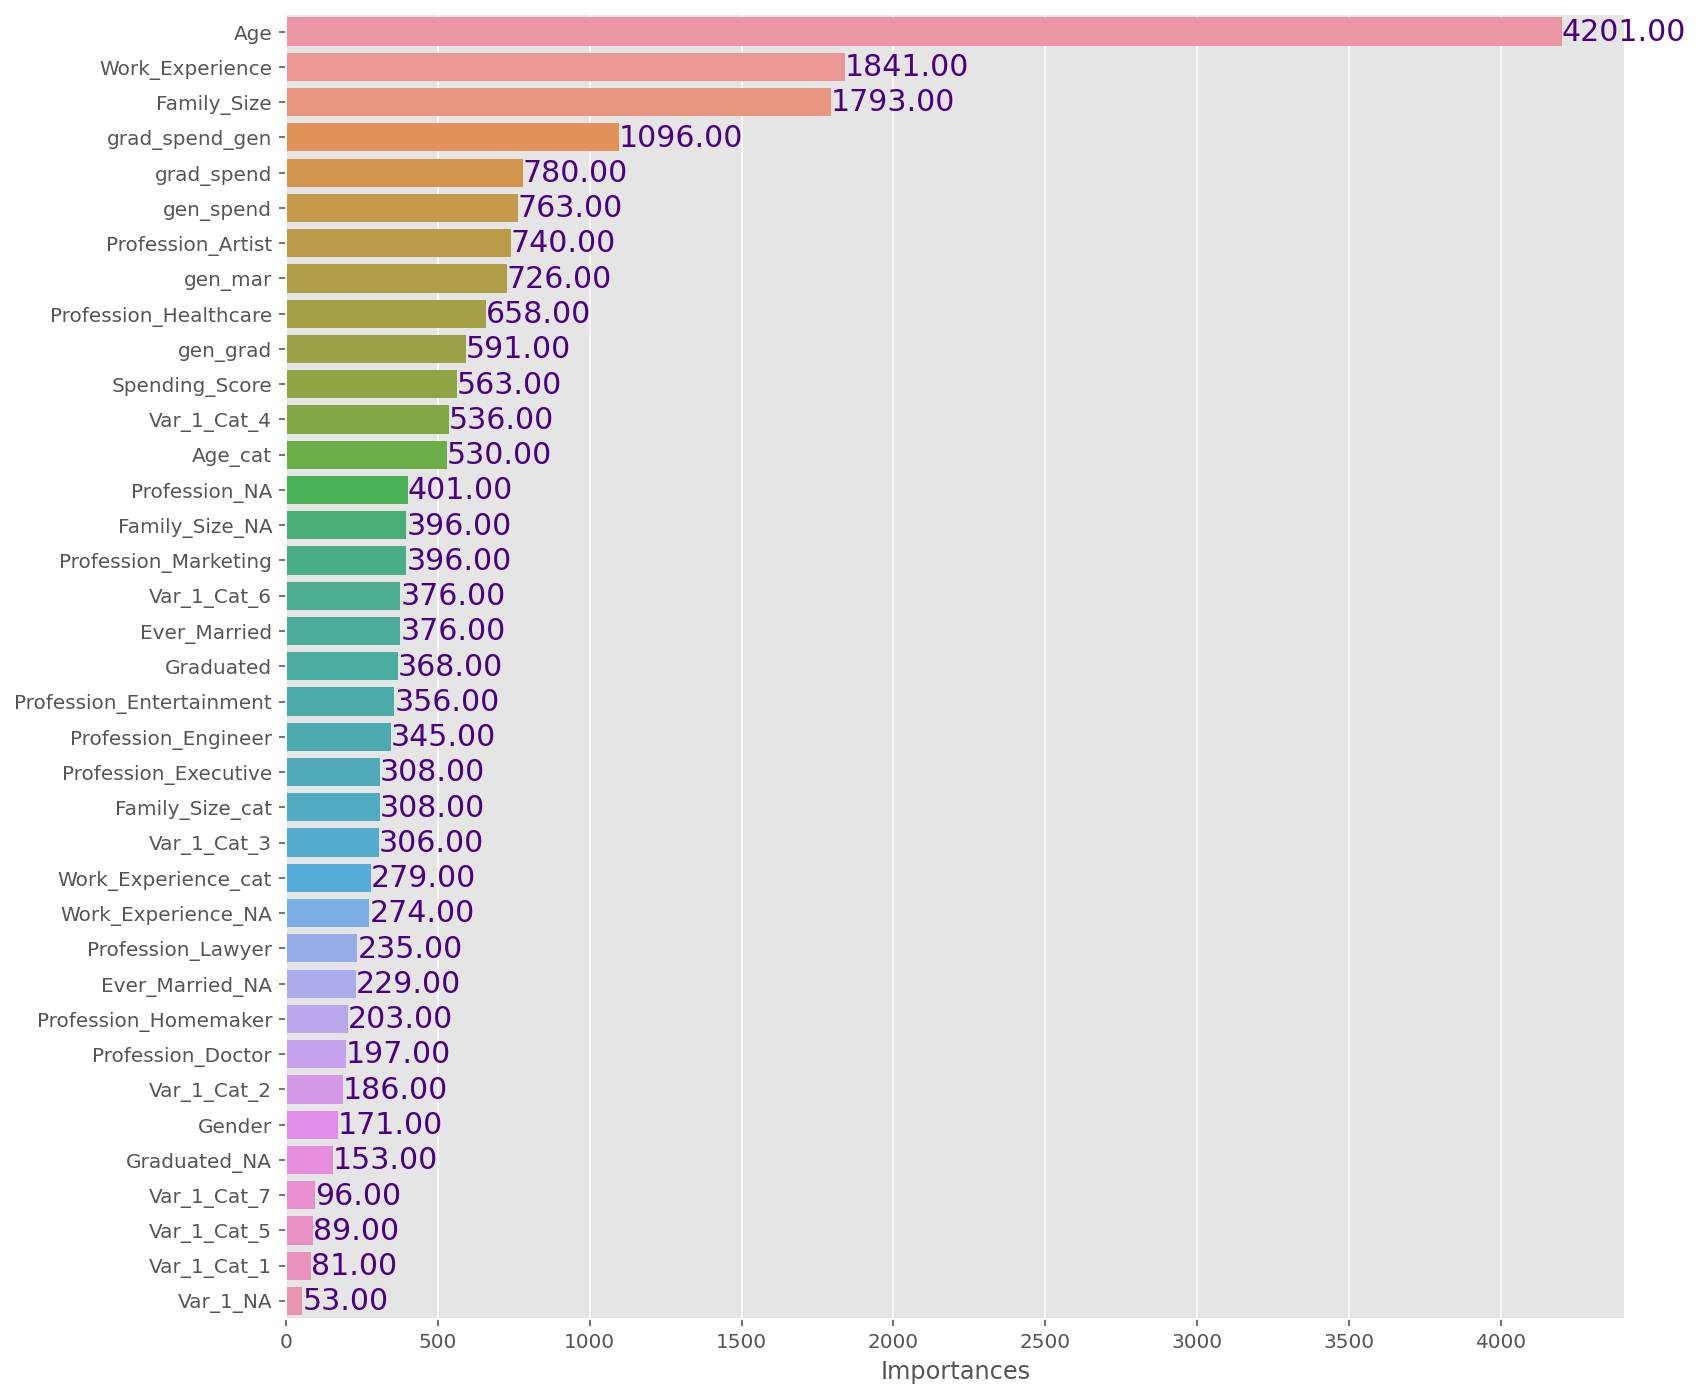

In [16]:
arr_fimp = clf_lgb.feature_importances_
df_fimp = pd.DataFrame(arr_fimp,columns=['Importances'],index=df.columns.drop(target))
df_fimp = df_fimp.sort_values('Importances',ascending=False)

plt.figure(figsize=(12,12))
ax = sns.barplot(x=df_fimp.Importances, y= df_fimp.index);

for p in ax.patches:
    x = p.get_width()
    y = p.get_y()
    text = '{:.2f}'.format(p.get_width())
    ax.text(x, y,text,fontsize=15,color='indigo',va='top',ha='left')

# Model interpretation using eli5

In [17]:
import eli5

eli5.show_weights(clf_lgb)

/Users/poudel/opt/miniconda3/envs/dataSc/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/poudel/opt/miniconda3/envs/dataSc/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [18]:
from eli5.sklearn import PermutationImportance

feature_names = df_Xtrain.columns.tolist()
perm = PermutationImportance(clf_lgb).fit(df_Xtest, ytx)
eli5.show_weights(perm, feature_names=feature_names)

# Model interpretation using lime

In [19]:
df.head(2)

Gender  Ever_Married  Age  Graduated  Work_Experience  Spending_Score  \
0       0             0   22          0              1.0               0   
1       1             1   38          1              3.0               1   

   Family_Size  Segmentation  Ever_Married_NA  Graduated_NA  Profession_NA  \
0          4.0             3                0             0              0   
1          3.0             0                0             0              0   

   Work_Experience_NA  Family_Size_NA  Var_1_NA  Age_cat  Family_Size_cat  \
0                   0               0         0        0                1   
1                   1               0         0        1                1   

   Work_Experience_cat  Profession_Artist  Profession_Doctor  \
0                    0                  0                  0   
1                    1                  0                  0   

   Profession_Engineer  Profession_Entertainment  Profession_Executive  \
0                    0                         0                     0   
1                    1                         0                     0   

   Profession_Healthcare  Profession_Homemaker  Profession_Lawyer  \
0                      1                     0                  0   
1                      0                     0                  0   

   Profession_Marketing  Var_1_Cat_1  Var_1_Cat_2  Var_1_Cat_3  Var_1_Cat_4  \
0                     0            0            0            0            1   
1                     0            0            0            0            1   

   Var_1_Cat_5  Var_1_Cat_6  Var_1_Cat_7  gen_mar  gen_grad  gen_spend  \
0            0            0            0        0         0          0   
1            0            0            0        3         3          4   

   grad_spend  grad_spend_gen  
0           0               0  
1           4              13

In [20]:
idx = 0
example = df_Xtest.iloc[idx]
answer = ser_ytest.iloc[idx]
feature_names = df_Xtest.columns.tolist()

prediction = clf_lgb.predict(example.to_numpy().reshape(-1,1).T)


print(f'answer     = {answer}')
print('prediction = ', prediction[0])
print()
print(example)
print(feature_names)

answer     = 2
prediction =  1

Gender                       0.0
Ever_Married                 1.0
Age                         47.0
Graduated                    1.0
Work_Experience             13.0
Spending_Score               0.0
Family_Size                  1.0
Ever_Married_NA              0.0
Graduated_NA                 0.0
Profession_NA                0.0
Work_Experience_NA           0.0
Family_Size_NA               0.0
Var_1_NA                     0.0
Age_cat                      1.0
Family_Size_cat              0.0
Work_Experience_cat          2.0
Profession_Artist            1.0
Profession_Doctor            0.0
Profession_Engineer          0.0
Profession_Entertainment     0.0
Profession_Executive         0.0
Profession_Healthcare        0.0
Profession_Homemaker         0.0
Profession_Lawyer            0.0
Profession_Marketing         0.0
Var_1_Cat_1                  0.0
Var_1_Cat_2                  0.0
Var_1_Cat_3                  0.0
Var_1_Cat_4                  0.0
Var_1_Cat_5

In [21]:
df.head(2)

Gender  Ever_Married  Age  Graduated  Work_Experience  Spending_Score  \
0       0             0   22          0              1.0               0   
1       1             1   38          1              3.0               1   

   Family_Size  Segmentation  Ever_Married_NA  Graduated_NA  Profession_NA  \
0          4.0             3                0             0              0   
1          3.0             0                0             0              0   

   Work_Experience_NA  Family_Size_NA  Var_1_NA  Age_cat  Family_Size_cat  \
0                   0               0         0        0                1   
1                   1               0         0        1                1   

   Work_Experience_cat  Profession_Artist  Profession_Doctor  \
0                    0                  0                  0   
1                    1                  0                  0   

   Profession_Engineer  Profession_Entertainment  Profession_Executive  \
0                    0                         0                     0   
1                    1                         0                     0   

   Profession_Healthcare  Profession_Homemaker  Profession_Lawyer  \
0                      1                     0                  0   
1                      0                     0                  0   

   Profession_Marketing  Var_1_Cat_1  Var_1_Cat_2  Var_1_Cat_3  Var_1_Cat_4  \
0                     0            0            0            0            1   
1                     0            0            0            0            1   

   Var_1_Cat_5  Var_1_Cat_6  Var_1_Cat_7  gen_mar  gen_grad  gen_spend  \
0            0            0            0        0         0          0   
1            0            0            0        3         3          4   

   grad_spend  grad_spend_gen  
0           0               0  
1           4              13

In [22]:
import lime
import lime.lime_tabular

categorical_features = ['Gender', 'Ever_Married', 'Graduated',
                        'Ever_Married_NA', 'Graduated_NA', 'Profession_NA',
                        'Work_Experience_NA', 'Family_Size_NA', 'Var_1_NA',

                        'Age_cat', 'Family_Size_cat', 'Work_Experience_cat',

                        'Profession_Artist', 'Profession_Doctor',
                        'Profession_Engineer', 'Profession_Entertainment',
                        'Profession_Executive', 'Profession_Healthcare',
                        'Profession_Homemaker', 'Profession_Lawyer',
                        'Profession_Marketing',

                        'Var_1_Cat_1', 'Var_1_Cat_2', 'Var_1_Cat_3',
                        'Var_1_Cat_4', 'Var_1_Cat_5', 'Var_1_Cat_6',
                        'Var_1_Cat_7'
                        ]


categorical_features_idx = [df_Xtrain.columns.get_loc(col) 
                              for col in categorical_features]
feature_names = df_Xtrain.columns
NUM_FEATURES = len(feature_names)
explainer = lime.lime_tabular.LimeTabularExplainer(df_Xtrain.to_numpy(), 
               feature_names=feature_names,
               categorical_features = categorical_features_idx,
               class_names=list('ABCD'), 
               mode='classification')

exp = explainer.explain_instance(example, clf_lgb.predict_proba,
                                 num_features=NUM_FEATURES)
exp.show_in_notebook(show_table=True)

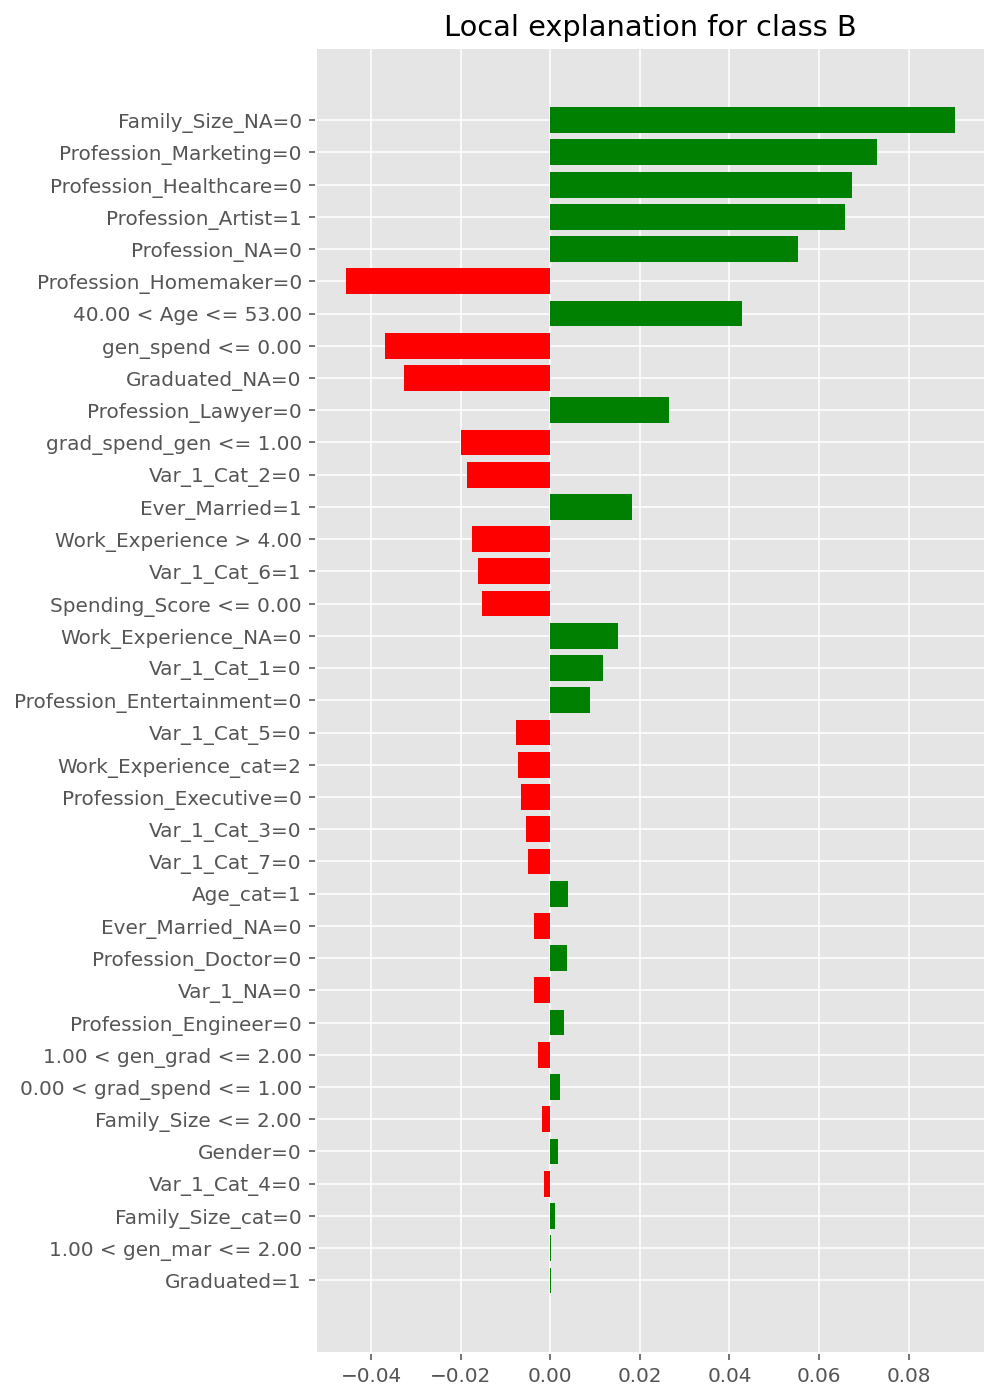

In [23]:
ax = exp.as_pyplot_figure(); # use semicolon
ax.set_figheight(12);

# Model interpretation using shap

In [24]:
import shap

shap.initjs()

In [25]:
%%time

explainer = shap.TreeExplainer(clf_lgb)
shap_values = np.array(explainer.shap_values(df_Xtest))

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


CPU times: user 10.8 s, sys: 941 ms, total: 11.8 s
Wall time: 6.65 s


In [26]:
df_Xtest.shape, explainer.expected_value, type(explainer.expected_value), len(explainer.expected_value)

((1614, 37),
 [-1.590906964825092,
  -1.5659766610613586,
  -1.665816205922094,
  -1.835565197951154],
 list,
 4)

In [27]:
idx = 5
shap.force_plot(explainer.expected_value[1],
                shap_values[1][idx,:],
                df_Xtest.iloc[idx,:] # this is just for giving feature names
               )

In [28]:
# many points
NUM = 1000
shap.force_plot(explainer.expected_value[1],
                shap_values[1][:NUM,:],
                df_Xtest.iloc[:NUM,:] # this is just for giving feature names
               )

In [29]:
shap_values.shape, df_Xtest.shape

((4, 1614, 37), (1614, 37))

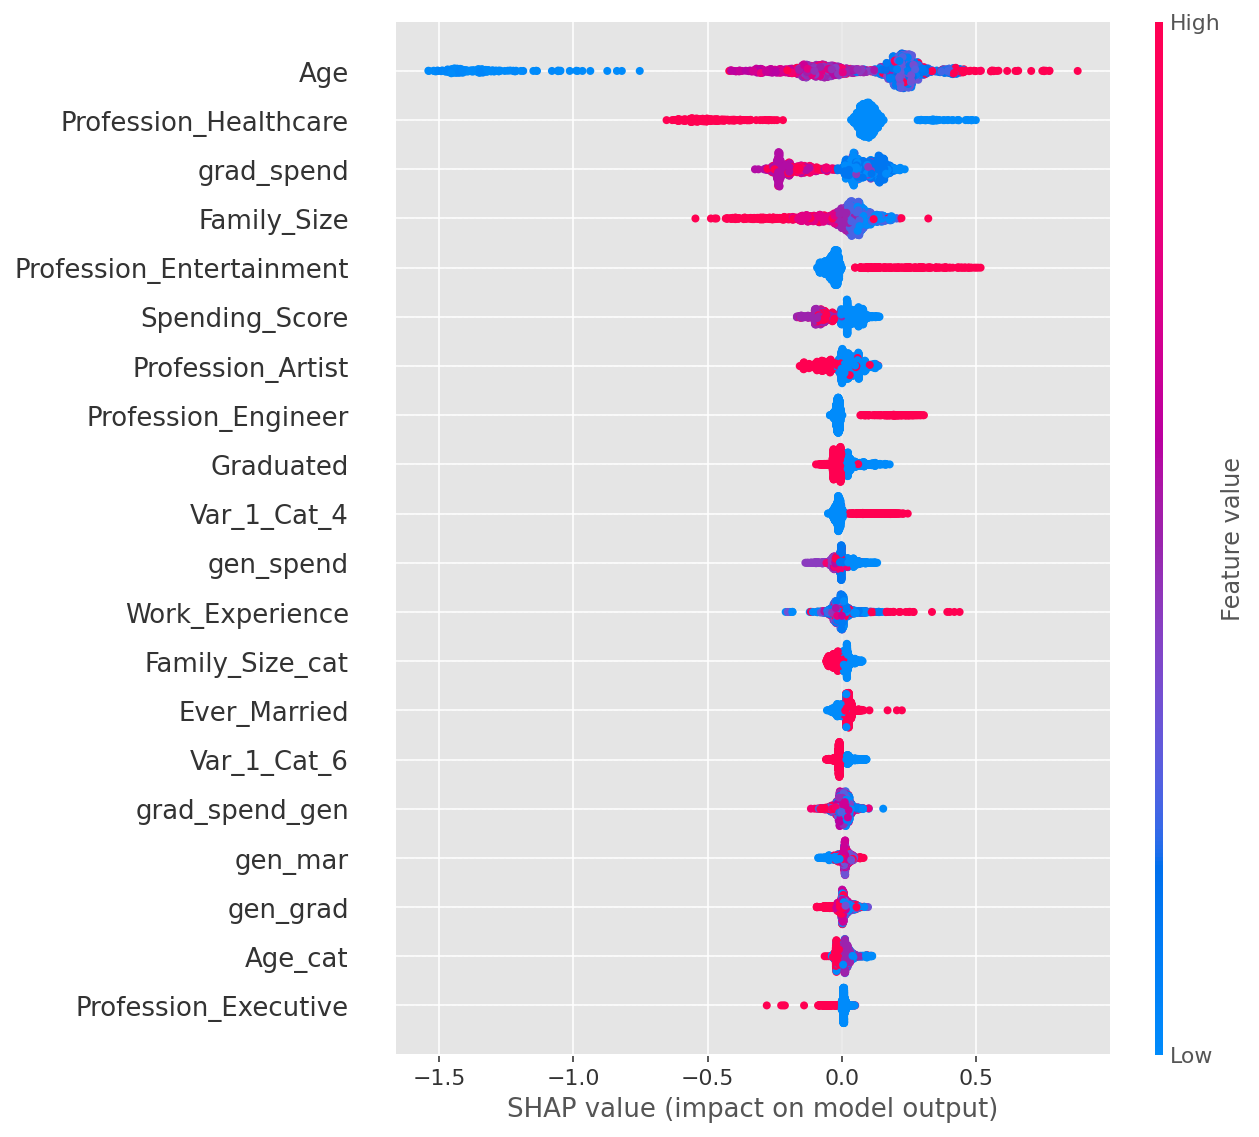

In [30]:
shap.summary_plot(shap_values[0], df_Xtest)